In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

In [8]:
pip --list

pip 23.3.1 from C:\Users\ec321\anaconda3\Lib\site-packages\pip (python 3.11)

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root='./test_set', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder(root='./training_set', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model initialization
from network import CNN  # Assuming network.py is in the same directory
model = CNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/20, Train Loss: 2.0251, Val Loss: 1.2595
Epoch 2/20, Train Loss: 0.7163, Val Loss: 0.8351
Epoch 3/20, Train Loss: 0.5557, Val Loss: 0.8401
Epoch 4/20, Train Loss: 0.4845, Val Loss: 0.6618
Epoch 5/20, Train Loss: 0.3889, Val Loss: 0.6356
Epoch 6/20, Train Loss: 0.3403, Val Loss: 0.6546
Epoch 7/20, Train Loss: 0.3109, Val Loss: 0.8465
Epoch 8/20, Train Loss: 0.2528, Val Loss: 0.7998
Epoch 9/20, Train Loss: 0.2699, Val Loss: 0.8086
Epoch 10/20, Train Loss: 0.2169, Val Loss: 0.8328
Epoch 11/20, Train Loss: 0.1165, Val Loss: 0.9346
Epoch 12/20, Train Loss: 0.1028, Val Loss: 0.9738
Epoch 13/20, Train Loss: 0.1628, Val Loss: 1.0793
Epoch 14/20, Train Loss: 0.1299, Val Loss: 1.0247
Epoch 15/20, Train Loss: 0.0609, Val Loss: 1.1945
Epoch 16/20, Train Loss: 0.0258, Val Loss: 1.3408
Epoch 17/20, Train Loss: 0.0512, Val Loss: 2.4998
Epoch 18/20, Train Loss: 0.0857, Val Loss: 1.5351
Epoch 19/20, Train Loss: 0.0827, Val Loss: 1.7317
Epoch 20/20, Train Loss: 0.0999, Val Loss: 1.4863


In [2]:
# モデル全体の保存
torch.save(model, 'model.pth')

NameError: name 'model' is not defined

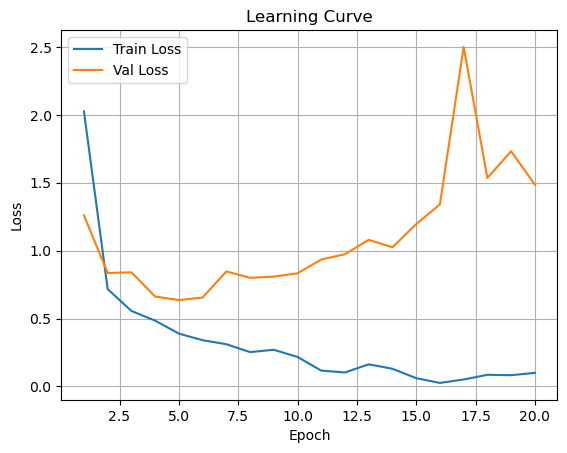

In [21]:
# Plotting learning curves
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid()
plt.legend()
plt.show()


In [3]:
model = torch.load("model.pth")

In [4]:
# URL-based prediction function
def predict_from_url(url):
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    ])
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_transformed = transform(img).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img_transformed)
        probability = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
        class_names = ['Cat', 'Dog']
        return class_names[predicted.item()], probability.tolist()[0]

In [7]:
url = "https://pets-kojima.com/assets/image/pet_type/%E3%82%B9%E3%82%B3.png"

In [8]:
predicted_class, probabilities = predict_from_url(url)
print(f"Predicted class: {predicted_class}")
print(f"Probability(Cat): {probabilities[0]}")
print(f"Probability(Dog): {probabilities[1]}")

Predicted class: Cat
Probability(Cat): 0.9970195889472961
Probability(Dog): 0.0029803479555994272
